In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# classification model
from sklearn.ensemble import RandomForestClassifier

# time it
import time

In [2]:
def read_datafiles(path):
    '''
    read and concat all files under the given path
    '''
    fileList = glob.glob(path+'*')
    df = pd.DataFrame()
    for f in fileList:
        df = pd.concat([df,pd.read_csv(f)], axis=0, ignore_index=True)
    return df

In [3]:
# read samples of train data
PATH_TO_TRAIN = '../data/train/'
train = read_datafiles(PATH_TO_TRAIN)

# read samples of dev data
PATH_TO_DEV = '../data/dev/'
dev = read_datafiles(PATH_TO_DEV)

# read samples of test data
PATH_TO_TEST = '../data/test/'
test = read_datafiles(PATH_TO_TEST)

In [4]:
# global helper list
aminoAcidList = ['A','R','N','D','C',
                 'Q','E','G','H','I',
                 'L','K','M','F','P',
                 'S','T','W','Y','V',
                 'X','U','B','O','Z','.']

In [5]:
# class occurence counts
countFreq = train.family_accession.value_counts()

# restrict to the 500 most populated classes
mostPopular = countFreq.index[:500]

In [6]:
# for simplicity, only the sufficiently populated classes are retained for the rest
# of the study
trainSub = train.loc[train.family_accession.isin(mostPopular)]

In [7]:
features = trainSub[['family_accession','sequence','aligned_sequence']]

In [8]:
features.shape

(294809, 3)

In [9]:
# length of the sequence and the aligned sequence
features.insert(features.shape[1], 'seqLen', value=features.sequence.apply(lambda x: len(x)).astype(np.uint16))
features.insert(features.shape[1], 'alignedSeqLen', value=features.aligned_sequence.apply(lambda x: len(x)).astype(np.uint16))

In [10]:
# proportion of each amino acid in the aligned sequence ("." included)
def get_proportion(seq, aminoAcid):
    return seq.count(aminoAcid)/len(seq)
for aminoAcid in aminoAcidList:
    features.insert(features.shape[1], 'proportion%s'%aminoAcid, value=features.aligned_sequence.apply(get_proportion,args=(aminoAcid,)).astype(np.float32))

In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294809 entries, 8 to 1086739
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   family_accession  294809 non-null  object 
 1   sequence          294809 non-null  object 
 2   aligned_sequence  294809 non-null  object 
 3   seqLen            294809 non-null  uint16 
 4   alignedSeqLen     294809 non-null  uint16 
 5   proportionA       294809 non-null  float32
 6   proportionR       294809 non-null  float32
 7   proportionN       294809 non-null  float32
 8   proportionD       294809 non-null  float32
 9   proportionC       294809 non-null  float32
 10  proportionQ       294809 non-null  float32
 11  proportionE       294809 non-null  float32
 12  proportionG       294809 non-null  float32
 13  proportionH       294809 non-null  float32
 14  proportionI       294809 non-null  float32
 15  proportionL       294809 non-null  float32
 16  proportionK       2

In [12]:
# group the above dataframe "features" by class and compute the class avg and std
byFamily = features.groupby(by='family_accession').agg(['mean','std'])
# sort the aggregated dataframe by the class frequency (descending ordre in frequency)
byFamily = byFamily.loc[countFreq.index[:len(mostPopular)]]

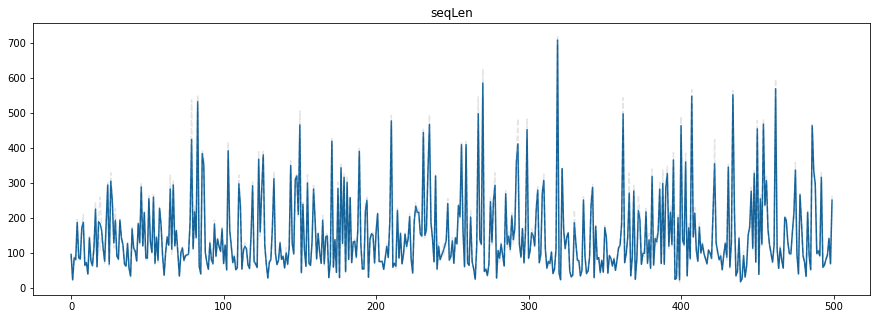

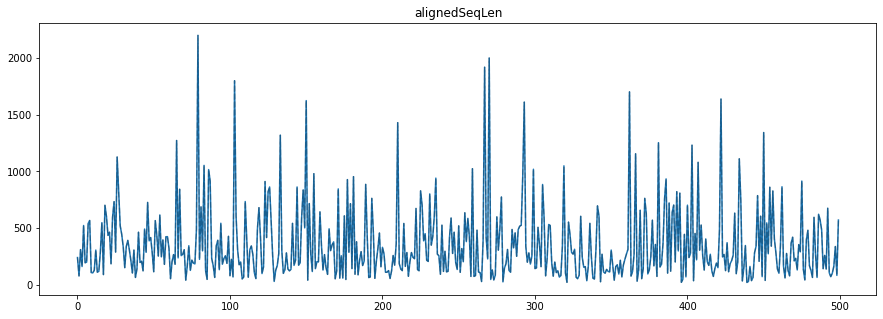

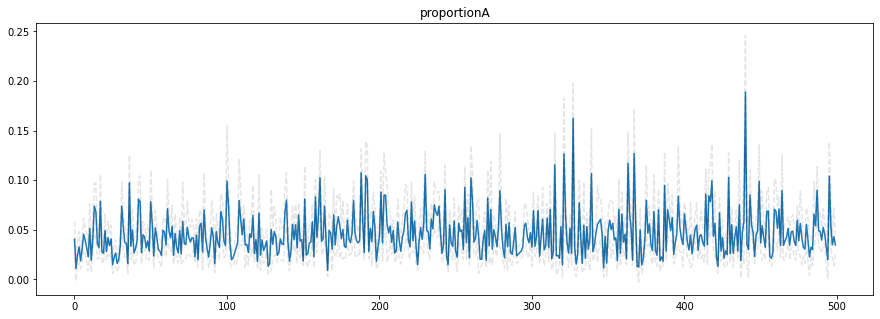

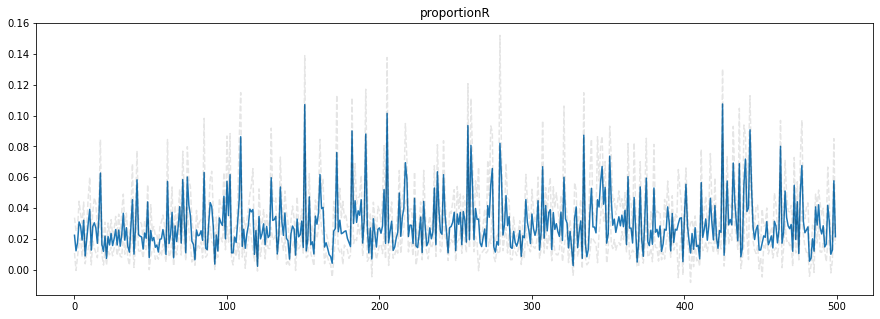

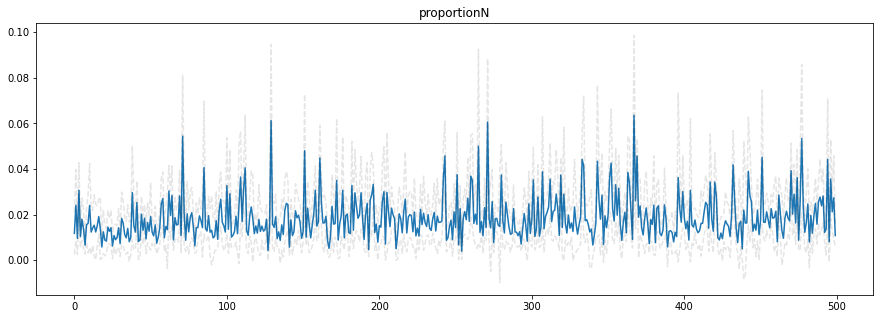

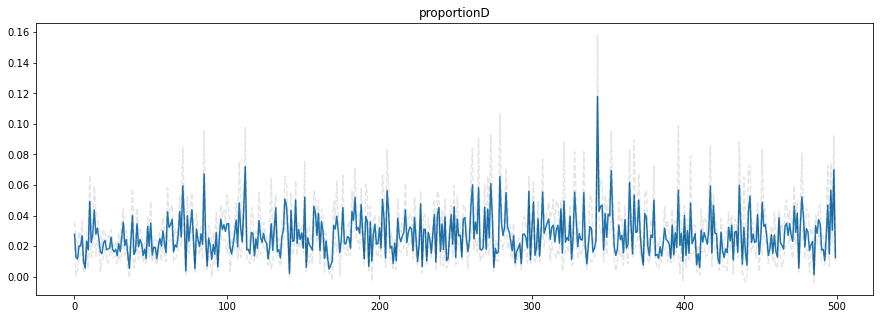

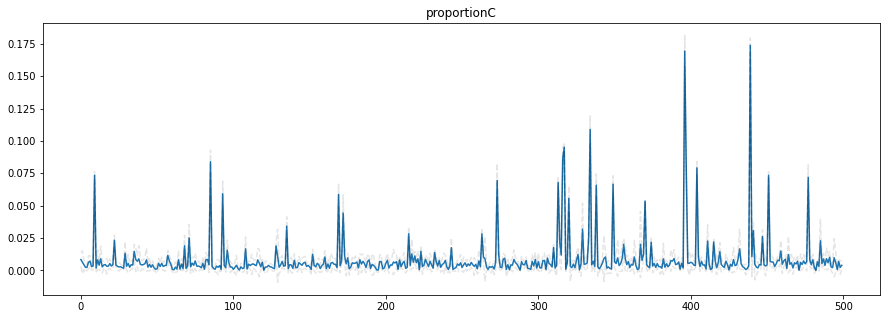

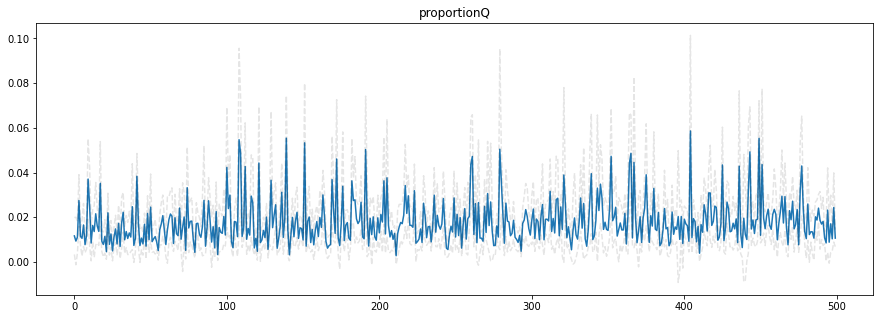

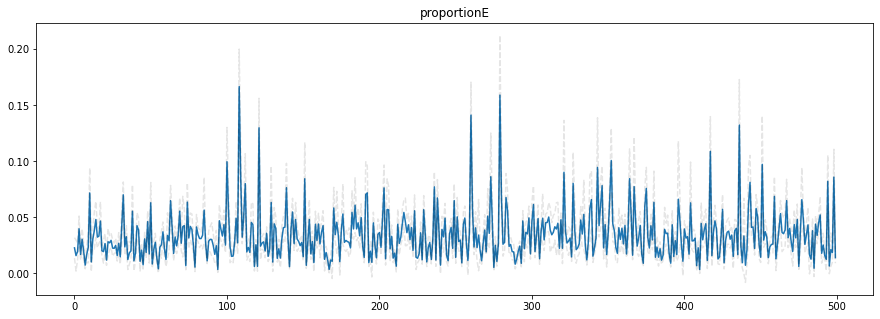

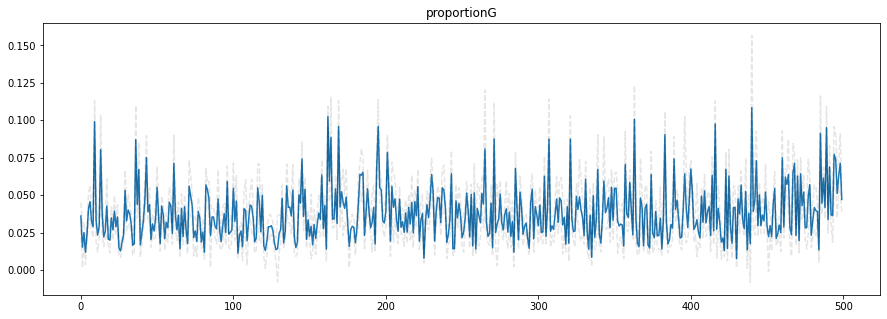

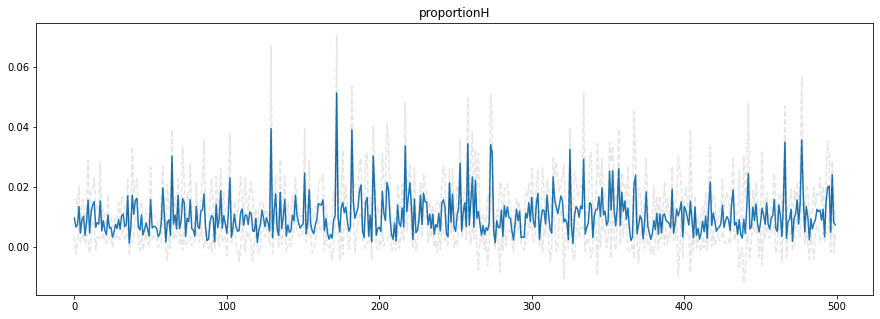

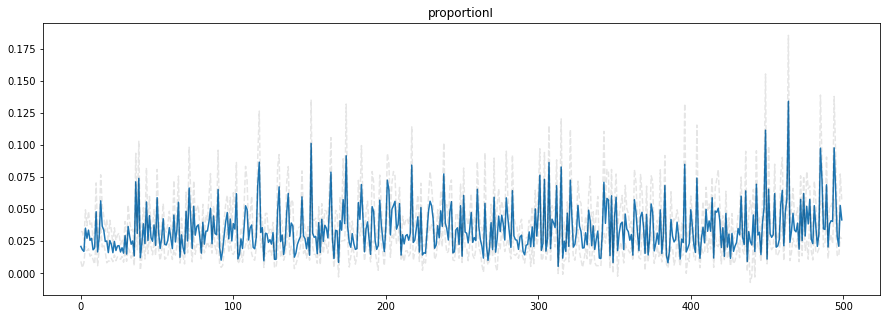

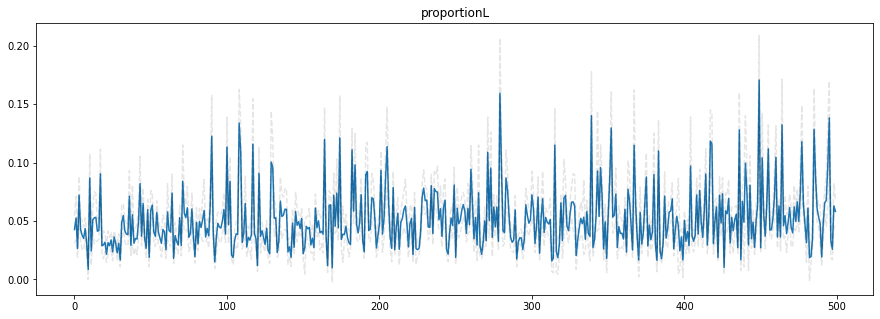

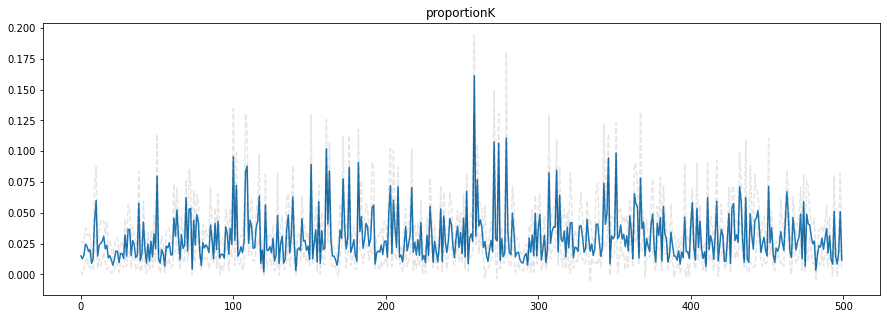

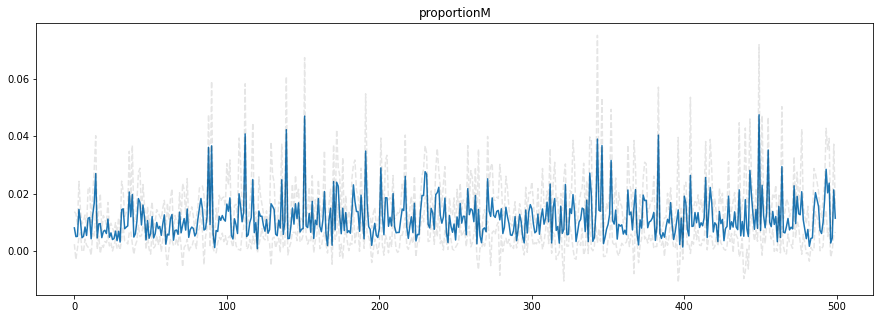

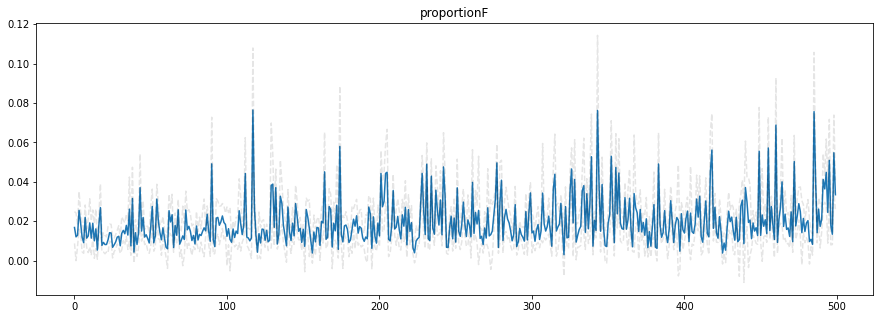

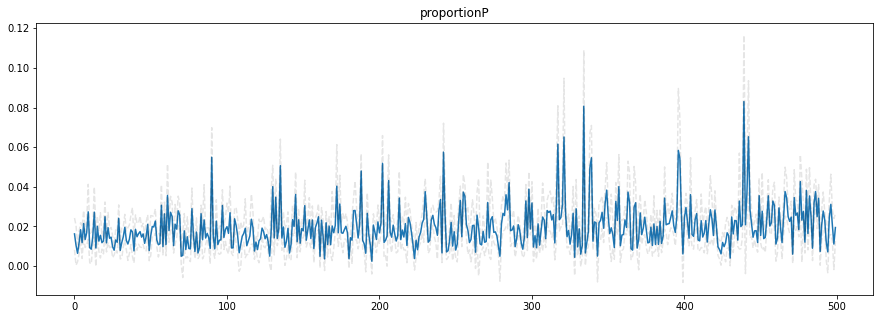

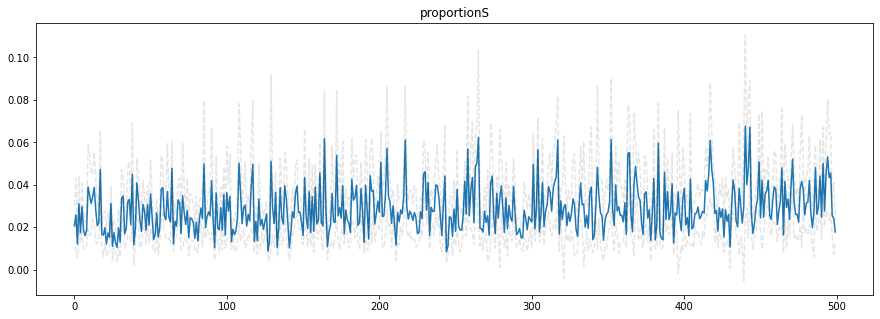

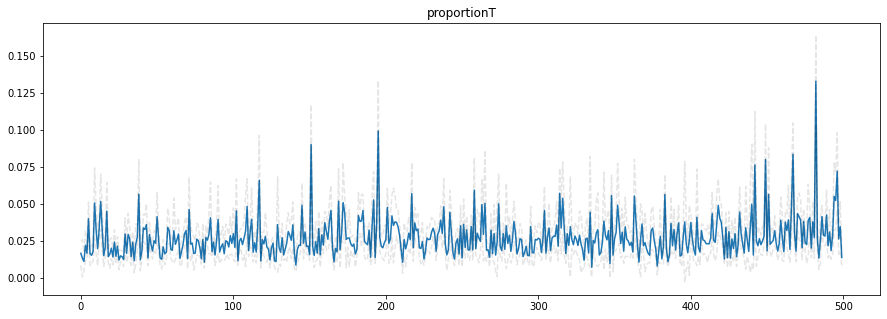

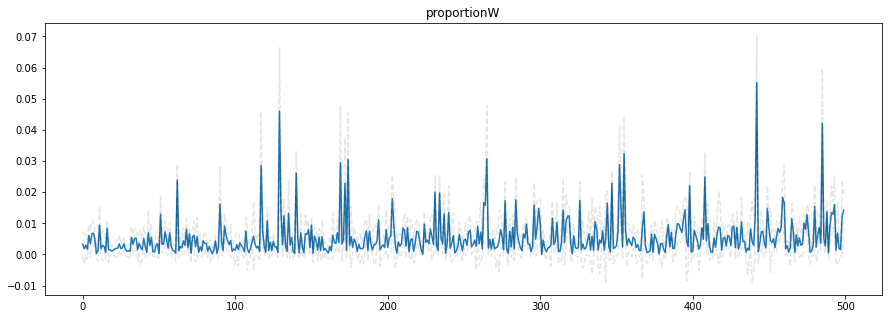

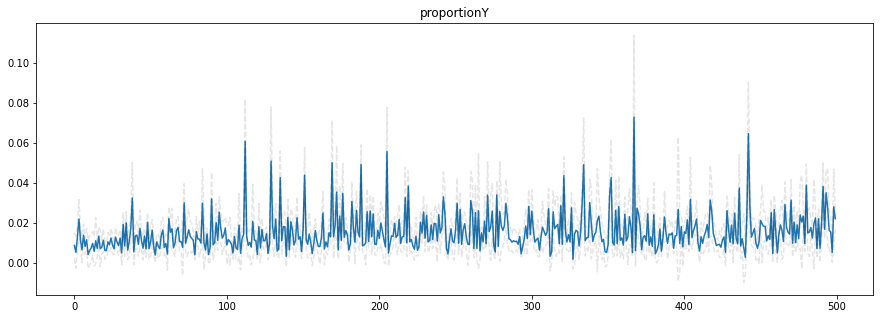

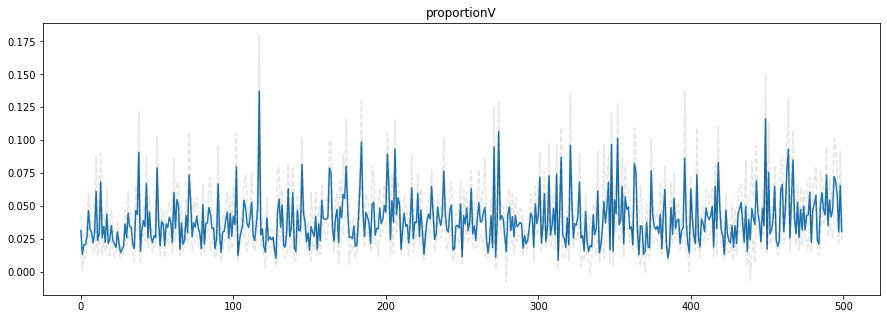

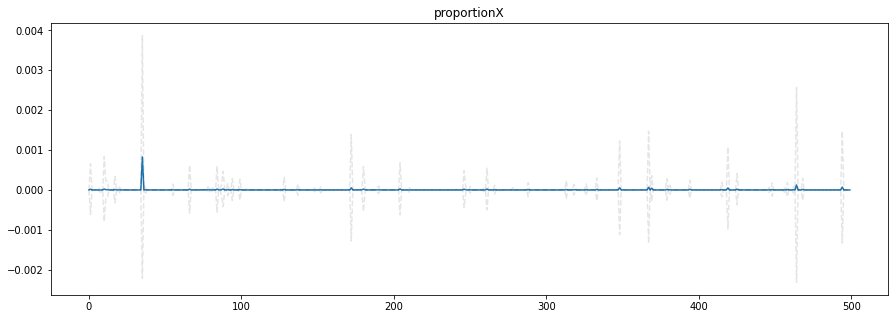

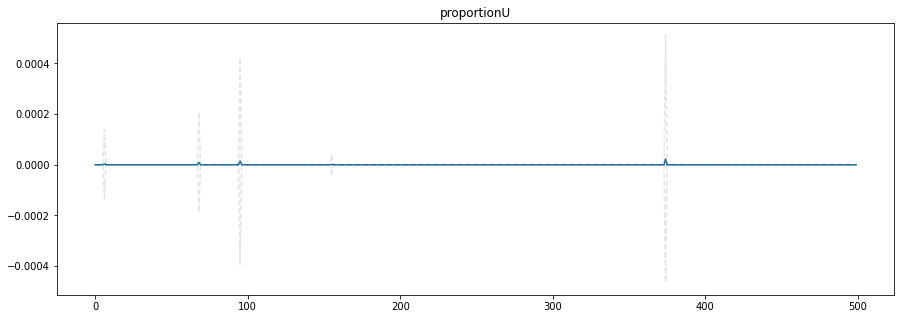

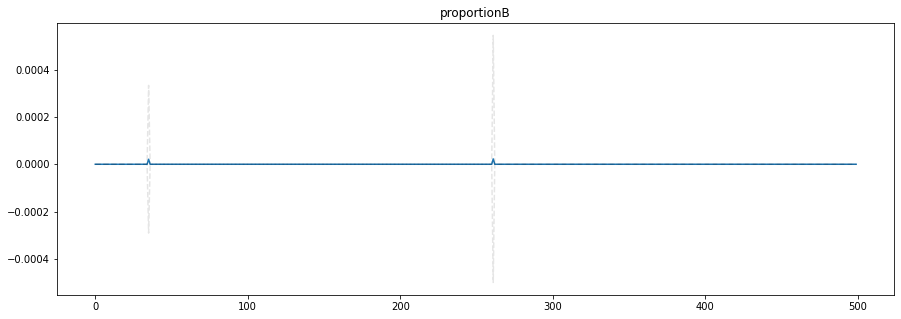

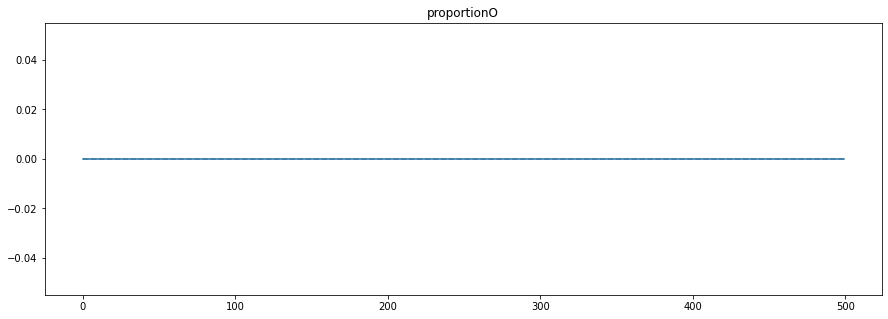

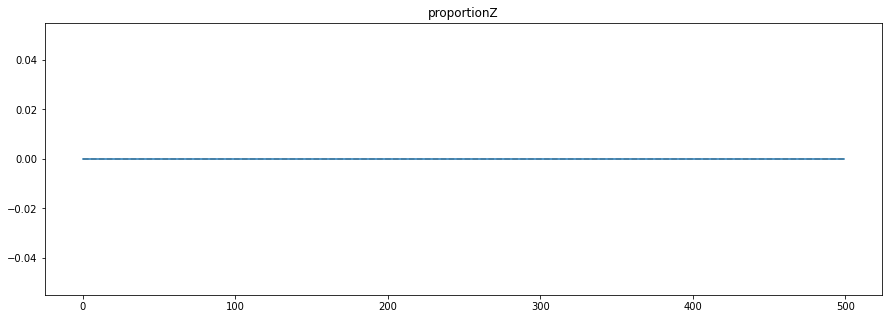

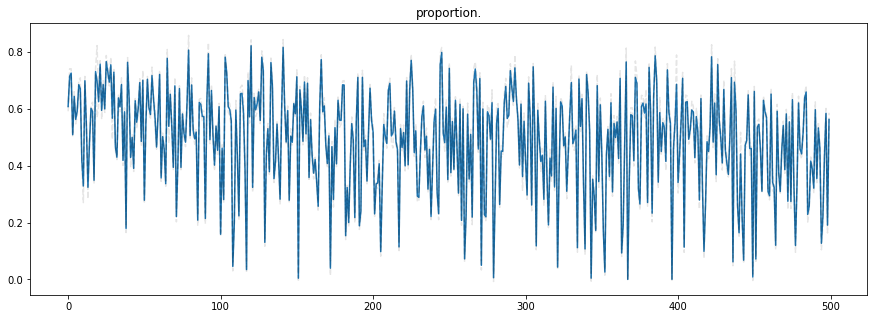

In [13]:
# a simple visualisation of the classes: class' mean and std of the above extracted features
for col in byFamily.columns.get_level_values(0)[::2]:
    plt.figure(figsize=(15,5))
    # plot mean +/- std of each feature
    plt.plot(byFamily[(col,'mean')].values)
    plt.plot(byFamily[(col,'mean')].values+byFamily[(col,'std')].values, 'k--', alpha=.1)
    plt.plot(byFamily[(col,'mean')].values-byFamily[(col,'std')].values, 'k--', alpha=.1)
    plt.title(col)
    plt.show()

### more on a single class

In [14]:
def convert_to_bin(seq):
    '''
    return a binary vector of the same length as seq, res[i] = 0 if seq[i] is "."; 1 otherwise
    '''
    # result vect to be returned, of the same length as the input sequence
    res = np.zeros(len(seq),dtype=bool)
    for i in range(len(seq)):
        res[i] = (seq[i] != '.')
    return res

def get_binarised_mat(subdf, colSeq='aligned_sequence'):
    '''
    stack the binary vector of each sequence to get a binary matrix
    this helps to visualise pattern of a bunch of sequences
    '''
    mat = np.zeros((subdf.shape[0],len(subdf[colSeq].iloc[0])), dtype=bool)
    for i in range(subdf.shape[0]):
        mat[i] = convert_to_bin(subdf[colSeq].iloc[i])
    return mat

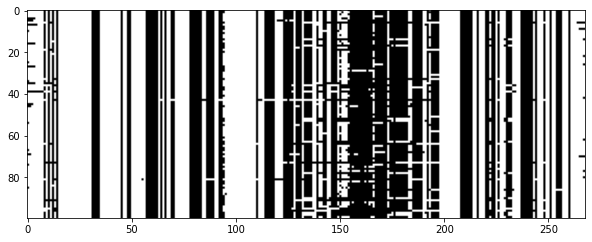

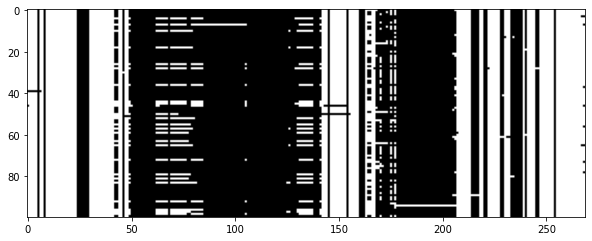

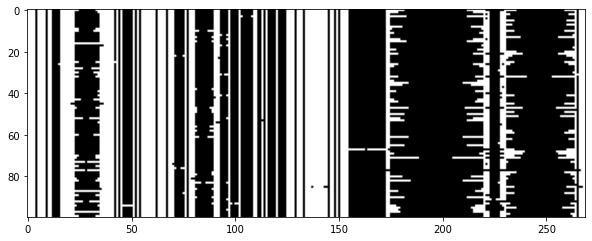

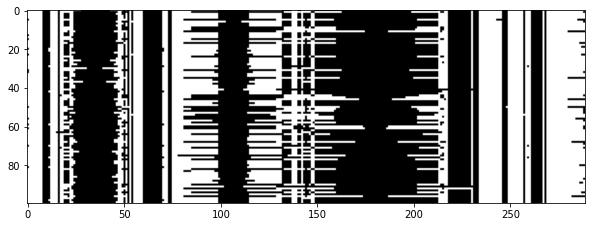

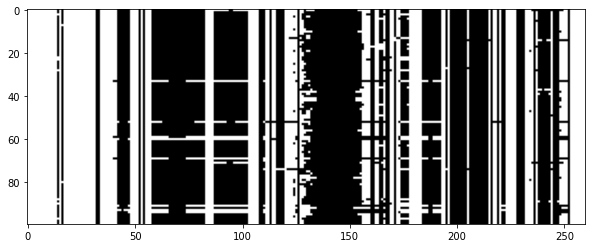

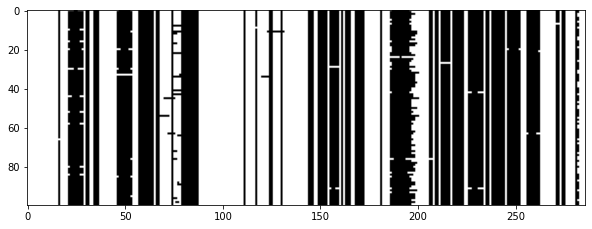

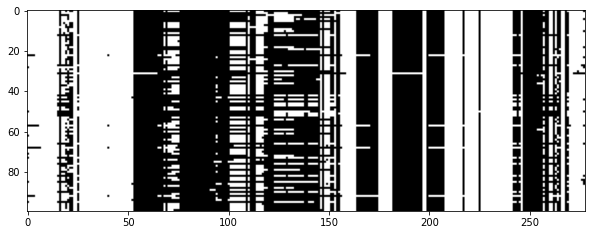

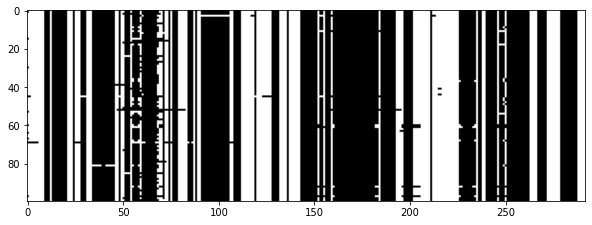

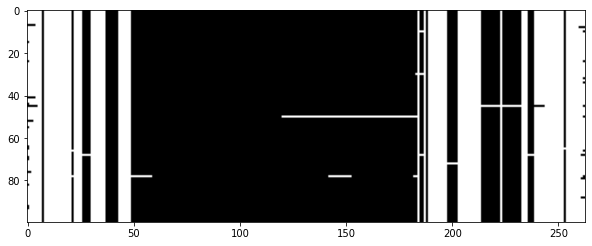

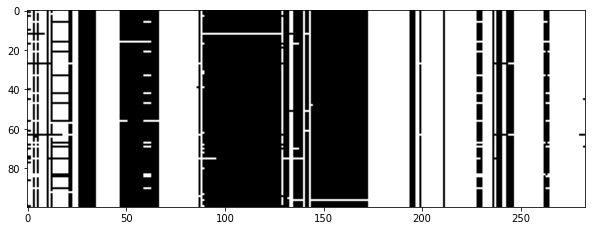

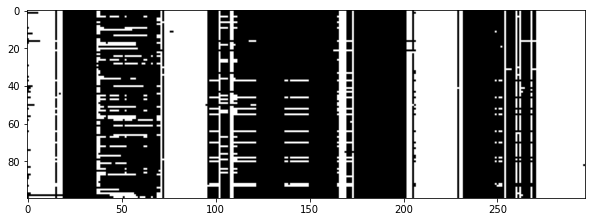

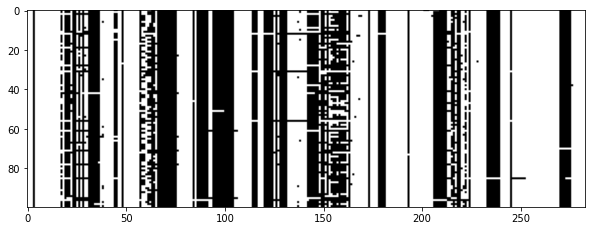

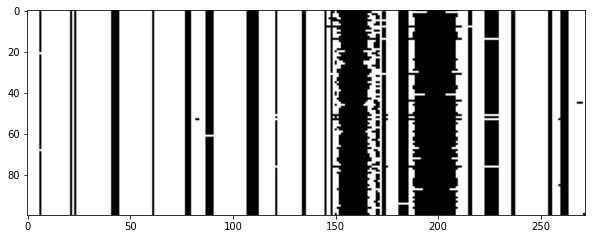

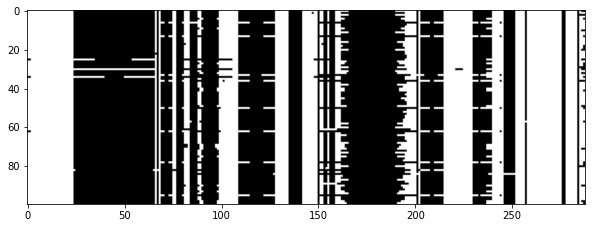

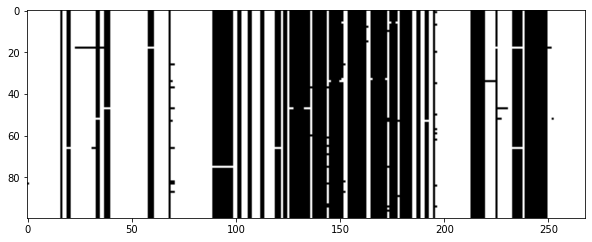

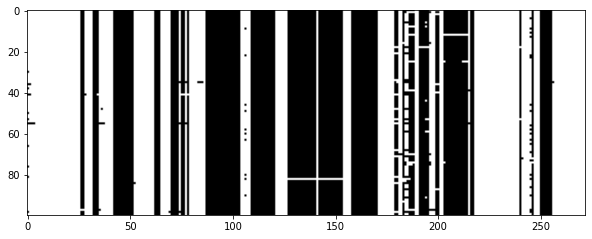

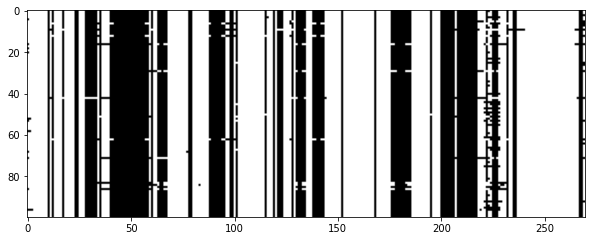

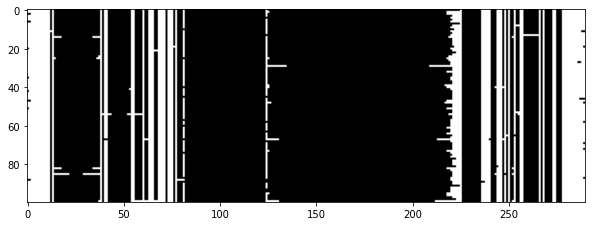

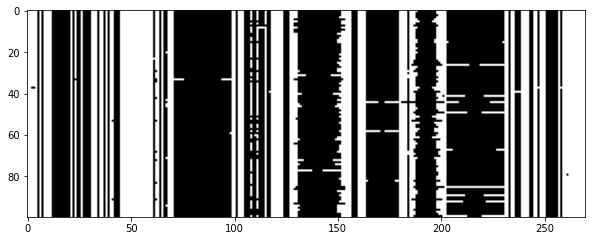

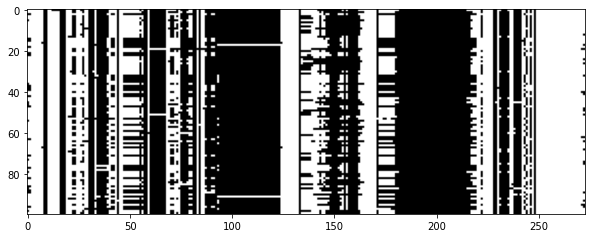

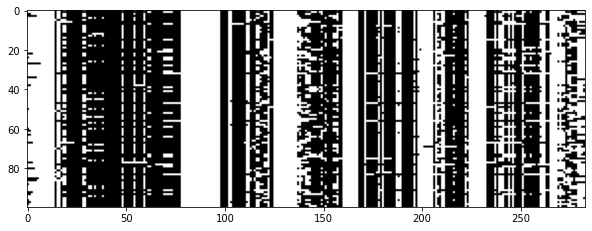

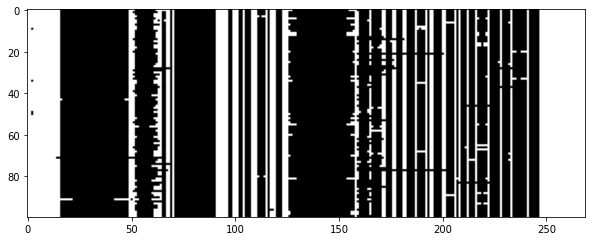

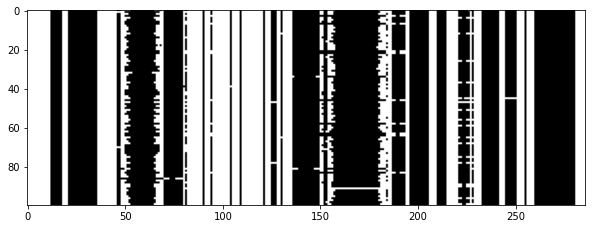

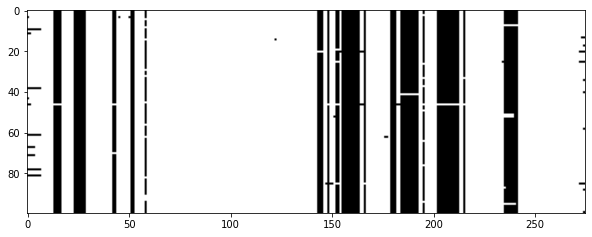

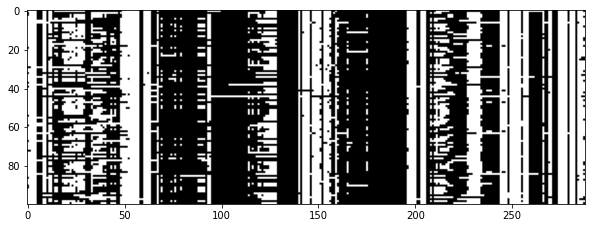

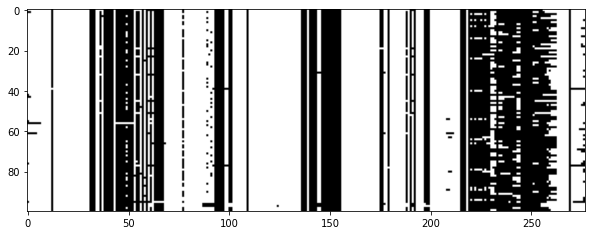

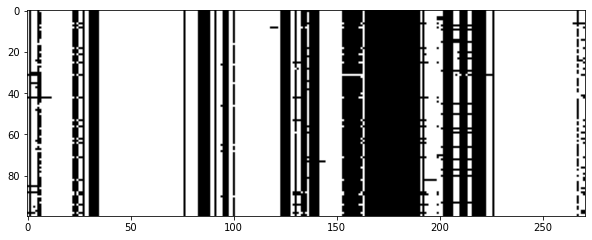

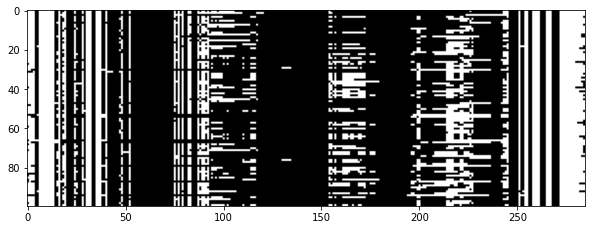

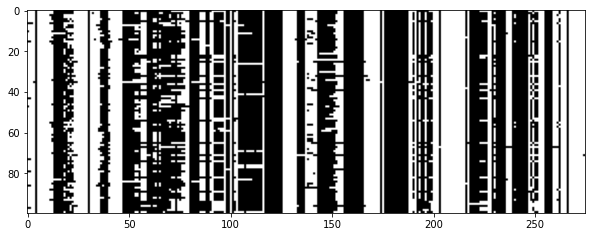

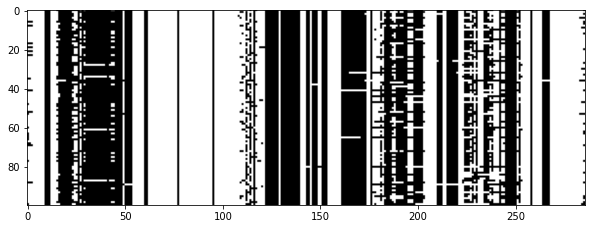

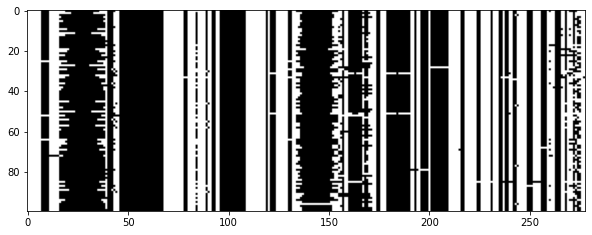

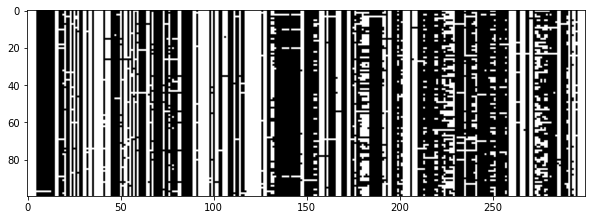

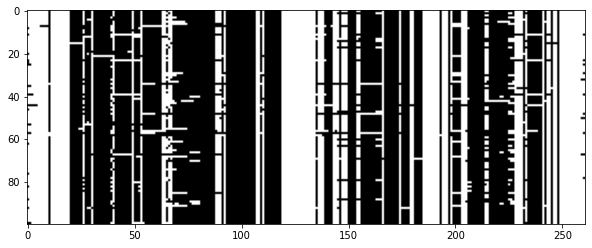

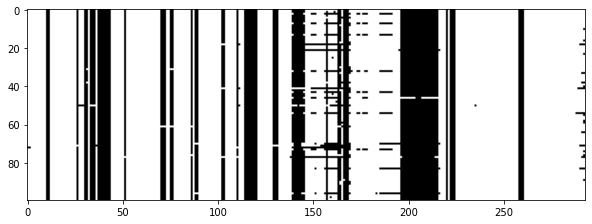

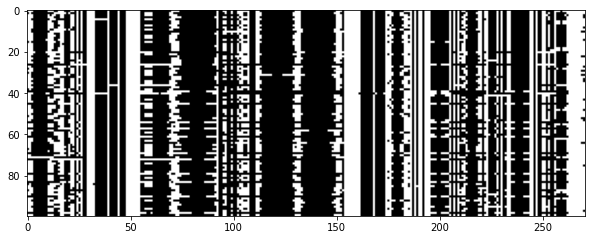

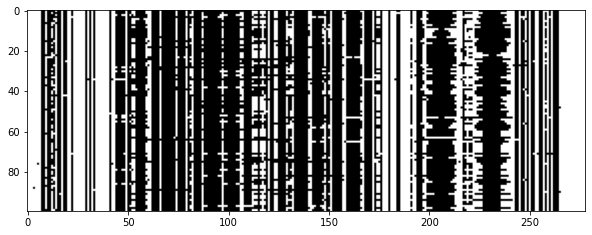

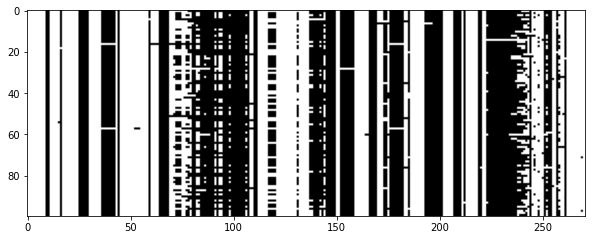

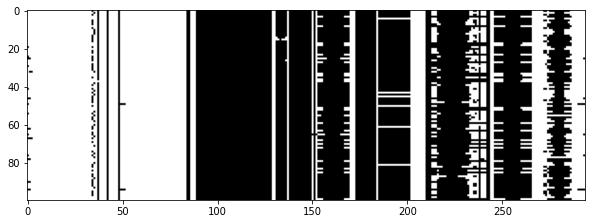

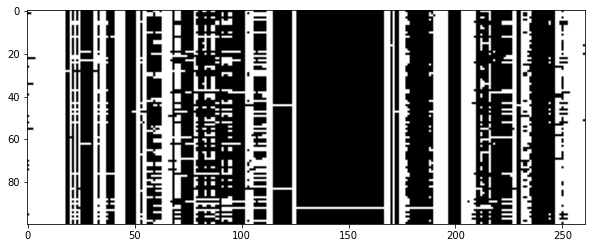

In [15]:
# let's see if there are some patterns in the aligned sequences that characterise a family
# 1. binarise the aligend seuqnce: '.' = 0 and 1 otherwise
# 2. stack all binarise sequences of the same protein family and plot the matrix
# Several protein families have the same aligned sequence length, for illustration I choose
# those having a length of N and select at most 100 family members to plot.
for fam in features.loc[(features.alignedSeqLen>=260)&(features.alignedSeqLen<=300),'family_accession'].unique():
    mat = get_binarised_mat(features.loc[features.family_accession==fam])
    plt.figure(figsize=(10,10))
    if mat.shape[0] > 100:
        # randomly choose 100 sequence for visualising
        idx = np.random.choice(np.arange(mat.shape[0]), size=100, replace=False)
    else:
        idx = np.arange(mat.shape[0])
    plt.imshow(mat[idx,:],'gray')
    plt.show()

In [16]:
# encode the binary pattern
# get the length of the longest possible aligned sequence
maxLen = features.alignedSeqLen.max() 
# maximum length of a segment of a sequence
# 64 because my pc is an 64bit machine, the max uint "affordable" is then 2**64-1
segmentSize = 64
# number of segments per sequence
# for short(er) sequences, use 0 padding
segmentNb = maxLen // segmentSize + 1

def encode_sequence_by_segment(seq, start, end, segmentSize):
    '''
    numerise the segment of the given sequence seq[start:end] by binary encoding.
    '''
    value = 0
    for i, c in enumerate(seq[start:end]):
        # if NOT gapped
        if c != '.':
            # (1 << n) := move "1" towards the left by n bits = 2**n
            # (x |= y) := conduct "|" (OR operation) bitwise between x and y and update x in place
            value |= 1 << (segmentSize-1-i)
    # out of for-loop
    # the loop creates a binary representation of a given segment computed on gaps, so the bin 
    # representation integrates the gap information; it then converts the binary representation 
    # to an unsigned integer, numerising the segment from string.
    return value

In [17]:
bitMask = trainSub[['family_accession','aligned_sequence']]
# apply the above defined encoding function to all the sequences
for i in range(segmentNb):
    vals = bitMask.aligned_sequence.apply(encode_sequence_by_segment,
                                          args=(i*segmentSize, (i+1)*segmentSize, segmentSize))
    bitMask.insert(loc=bitMask.shape[1],column='seg%d'%i, value=vals)

## Classification

### binary encoding features

In [20]:
testSub = test.loc[test.family_accession.isin(mostPopular)]
devSub = dev.loc[dev.family_accession.isin(mostPopular)]

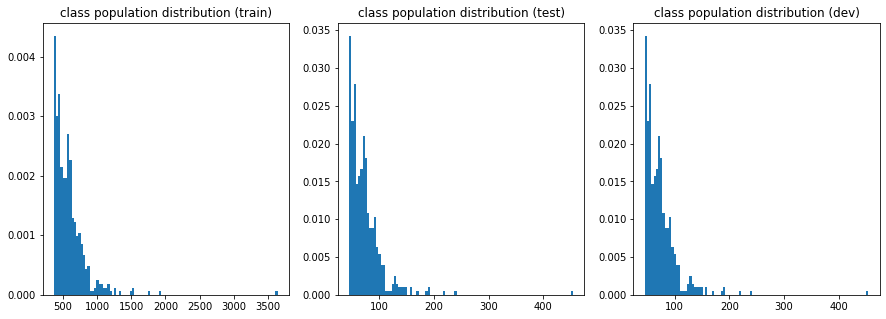

In [21]:
countFreqTr = trainSub.family_accession.value_counts()
countFreqTs = testSub.family_accession.value_counts()
countFreqDv = devSub.family_accession.value_counts()
fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(15,5))
axes[0].hist(countFreqTr, bins=100, density=True)
axes[0].set_title('class population distribution (train)')
axes[1].hist(countFreqTs, bins=100, density=True)
axes[1].set_title('class population distribution (test)')
axes[2].hist(countFreqDv, bins=100, density=True)
axes[2].set_title('class population distribution (dev)')
plt.show()

In [22]:
# process the test and dev data sets in the same way as the train set

## test
bitMaskTest = testSub[['family_accession','aligned_sequence']]
for i in range(segmentNb):
    vals = bitMaskTest.aligned_sequence.apply(encode_sequence_by_segment,
                                              args=(i*segmentSize, (i+1)*segmentSize, segmentSize))
    bitMaskTest.insert(loc=bitMaskTest.shape[1],column='seg%d'%i, value=vals)

## dev
bitMaskDev = devSub[['family_accession','aligned_sequence']]
for i in range(segmentNb):
    vals = bitMaskDev.aligned_sequence.apply(encode_sequence_by_segment,
                                              args=(i*segmentSize, (i+1)*segmentSize, segmentSize))
    bitMaskDev.insert(loc=bitMaskDev.shape[1],column='seg%d'%i, value=vals)

In [24]:
rfBit = RandomForestClassifier()
for _ in range(3):
    print('-------------------------')
    # randomly pick a third of the training population for model fitting
    # prevent program from crashing due to little memory
    idx = np.random.choice(np.arange(bitMask.shape[0]), size=bitMask.shape[0]//3, replace=False)
    tt = time.time()
    rfBit.fit(bitMask.iloc[idx,2:], bitMask.iloc[idx,0])
    print("Model fitted in %.2f seconds" % (time.time()-tt))
    print('testing...')
    tt = time.time()
    # lazy evaluation: mean accuracy of all top populated classes mixed up
    devScore = rfBit.score(bitMaskDev.iloc[:,2:], bitMaskDev.iloc[:,0])
    testScore = rfBit.score(bitMaskTest.iloc[:,2:], bitMaskTest.iloc[:,0])
    print("tests done in %.2f seconds" % (time.time()-tt))
    print('score on dev:', devScore)
    print('score on test:', testScore)
    

-------------------------
Model fitted in 23.60 seconds
testing...
tests done in 31.21 seconds
score on dev: 0.9869295343304805
score on test: 0.9864099969921523
-------------------------
Model fitted in 23.94 seconds
testing...
tests done in 30.30 seconds
score on dev: 0.9860818681468924
score on test: 0.9862732766399607
-------------------------
Model fitted in 23.30 seconds
testing...
tests done in 30.73 seconds
score on dev: 0.9870662546826721
score on test: 0.9864373410625906


### proportion of each amino acid 
(only runnable for limited number of classes)

In [25]:
# process the test and dev data sets in the same way as the train set

## test
featuresTest = testSub[['family_accession','sequence','aligned_sequence']]
# length of the sequence and the aligned sequence
featuresTest.insert(featuresTest.shape[1], 'seqLen', value=featuresTest.sequence.apply(lambda x: len(x)).astype(np.uint16))
featuresTest.insert(featuresTest.shape[1], 'alignedSeqLen', value=featuresTest.aligned_sequence.apply(lambda x: len(x)).astype(np.uint16))
# proportion of each amino acid in the aligned sequence ("." included)
for aminoAcid in aminoAcidList:
    featuresTest.insert(featuresTest.shape[1], 'proportion%s'%aminoAcid, value=featuresTest.aligned_sequence.apply(get_proportion,args=(aminoAcid,)).astype(np.float32))
    
## dev
featuresDev = devSub[['family_accession','sequence','aligned_sequence']]
# length of the sequence and the aligned sequence
featuresDev.insert(featuresDev.shape[1], 'seqLen', value=featuresDev.sequence.apply(lambda x: len(x)).astype(np.uint16))
featuresDev.insert(featuresDev.shape[1], 'alignedSeqLen', value=featuresDev.aligned_sequence.apply(lambda x: len(x)).astype(np.uint16))
# proportion of each amino acid in the aligned sequence ("." included)
for aminoAcid in aminoAcidList:
    featuresDev.insert(featuresDev.shape[1], 'proportion%s'%aminoAcid, value=featuresDev.aligned_sequence.apply(get_proportion,args=(aminoAcid,)).astype(np.float32))

In [26]:
featuresTest.head()

family_accession                                           sequence  \
1        PF01556.18  LRFITEIELEEVISGKEAQIEFDTEANCDDCNGSGAAKGSSATTCP...   
4         PF12911.7  SPAQQIRIKFRNNRLAMMGFYMFVTIVLLVVVTHFYTKFTGYDFAK...   
8         PF17802.1  KTNTILAGATLKVINKDTSEVIDTFVTTTTGHSIKGLKAGTYKVIE...   
9         PF10396.9  TIFGLSSGSGKCGVAVIRVSGDASSDVVHRKTSSNKLPAARQAVLR...   
12       PF09285.11  VVREVVYTEPAVKGDTSGKVMKPAKLATGYVLDVPAFVNTGDKIEI...   

                                     aligned_sequence  seqLen  alignedSeqLen  \
1   LRFITEIELEEVISG.K.E.....AQI......EF..............     214            447   
4   SPA.QQI..R.....I...KFRNNRLAMMGFYMFVT.IVL.L.......      56            120   
8   KTNT..IL..AGATLKVI...NK..........................      68            394   
9   TIFGLSS..G..S..G.K..C.G..VAVIRVSG................     118            389   
12  VVREVVYTEP.AVKG..DT............SGKV.MKPAKL.A.T...      56             81   

    proportionA  proportionR  proportionN  proportionD  proportionC  ...  \
1      0.022371     0.038031     0.015660     0.029083     0.017897  ...   
4      0.025000     0.025000     0.033333     0.016667     0.000000  ...   
8      0.015228     0.000000     0.010152     0.007614     0.000000  ...   
9      0.030848     0.023136     0.002571     0.015424     0.005141  ...   
12     0.049383     0.049383     0.012346     0.049383     0.000000  ...   

    proportionT  proportionW  proportionY  proportionV  proportionX  \
1      0.031320     0.000000     0.006711     0.038031          0.0   
4      0.050000     0.000000     0.025000     0.041667          0.0   
8      0.032995     0.000000     0.005076     0.012690          0.0   
9      0.012853     0.002571     0.005141     0.033419          0.0   
12     0.074074     0.000000     0.037037     0.111111          0.0   

    proportionU  proportionB  proportionO  proportionZ  proportion.  
1           0.0          0.0          0.0          0.0     0.521253  
4           0.0          0.0          0.0          0.0     0.533333  
8           0.0          0.0          0.0          0.0     0.827411  
9           0.0          0.0          0.0          0.0     0.696658  
12          0.0          0.0          0.0          0.0     0.308642  

[5 rows x 31 columns]

In [27]:
# the following code kills the kernel when nb classes gets too large. 
# might be due to bad seperation of the feature space (little information gain at each step when
# growing the trees)?
# run out of memory?
rfFeature = RandomForestClassifier()
for _ in range(3):
    print('-------------------------')
    # randomly pick a fifth of the training population for model fitting
    # prevent program from crashing due to little memory left...
    idx = np.random.choice(np.arange(features.shape[0]), size=features.shape[0]//4, replace=False)
    tt = time.time()
    # here the column "proportion." is left out since all propotions sum up to 1
    rfFeature.fit(features.iloc[idx,3:-1], features.iloc[idx,0])
    print("Model fitted in %.2f seconds" % (time.time()-tt))
    print('testing...')
    tt = time.time()
    # lazy evaluation: mean accuracy of all top populated classes mixed up
    devScore = rfFeature.score(featuresDev.iloc[:,3:-1], featuresDev.iloc[:,0]) 
    testScore = rfFeature.score(featuresTest.iloc[:,3:-1], featuresTest.iloc[:,0])
    print("tests done in %.2f seconds" % (time.time()-tt))
    print('score on dev:', devScore)
    print('score on test:', testScore)
    

-------------------------
Model fitted in 137.25 seconds
testing...
tests done in 47.81 seconds
score on dev: 0.9842498154275245
score on test: 0.984960761258921
-------------------------
Model fitted in 145.50 seconds
testing...
tests done in 44.25 seconds
score on dev: 0.9860271800060157
score on test: 0.9853982663859342
-------------------------
Model fitted in 142.91 seconds
testing...
tests done in 46.97 seconds
score on dev: 0.9869021902600421
score on test: 0.9866834376965355
